In [14]:
df_train = pd.read_csv("train.csv") # 학습용 데이터
df_test = pd.read_csv("submission.csv") # 테스트 데이터(제출파일의 데이터)

In [15]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,/Quezon City/Philippines,AS,0.066667,32160,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Engineering,0,True
1,1.0,/PH-00/Philippines,AS,0.066667,23122,End-Customer,Enterprise,12.0,NaN,NaN,...,LGEPH,less than 3 months,1,0,0.003079,0.026846,corporate / office,Advertising,1,True
2,1.0,/Kolkata /India,AS,0.088889,1755,End-Customer,Enterprise,144.0,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,Construction,2,True
3,1.0,/Bhubaneswar/India,AS,0.088889,4919,End-Customer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,1,0,0.003079,0.026846,corporate / office,IT/Software,3,True
4,1.0,/Hyderabad/India,AS,0.088889,17126,Specifier/ Influencer,Enterprise,NaN,NaN,NaN,...,LGEIL,less than 3 months,0,0,0.003079,0.026846,corporate / office,NaN,4,True


## 2. 데이터 전처리

### 레이블 인코딩

In [16]:
def label_encoding(series: pd.Series) -> pd.Series:
    """범주형 데이터를 시리즈 형태로 받아 숫자형 데이터로 변환합니다."""

    my_dict = {}

    # 모든 요소를 문자열로 변환
    series = series.astype(str)

    for idx, value in enumerate(sorted(series.unique())):
        my_dict[value] = idx
    series = series.map(my_dict)

    return series

In [17]:
# 레이블 인코딩할 칼럼들
label_columns = [
    "customer_country",
    "business_subarea",
    "business_area",
    "business_unit",
    "customer_type",
    "enterprise",
    "customer_job",
    "inquiry_type",
    "product_category",
    "product_subcategory",
    "product_modelname",
    "customer_country.1",
    "customer_position",
    "response_corporate",
    "expected_timeline",
]

df_all = pd.concat([df_train[label_columns], df_test[label_columns]])

for col in label_columns:
    df_all[col] = label_encoding(df_all[col])

다시 학습 데이터와 제출 데이터를 분리합니다.

In [18]:
for col in label_columns:  
    df_train[col] = df_all.iloc[: len(df_train)][col]
    df_test[col] = df_all.iloc[len(df_train) :][col]

In [19]:
df_train.head() # 학습용 데이터 살펴보기

,bant_submit,customer_country,business_unit,com_reg_ver_win_rate,customer_idx,customer_type,enterprise,historical_existing_cnt,id_strategic_ver,it_strategic_ver,...,response_corporate,expected_timeline,ver_cus,ver_pro,ver_win_rate_x,ver_win_ratio_per_bu,business_area,business_subarea,lead_owner,is_converted
0,1.0,9070,0,0.066667,32160,10,0,NaN,NaN,NaN,...,33,246,1,0,0.003079,0.026846,0,28,0,True
1,1.0,8406,0,0.066667,23122,10,0,12.0,NaN,NaN,...,33,246,1,0,0.003079,0.026846,0,0,1,True
2,1.0,6535,0,0.088889,1755,10,0,144.0,NaN,NaN,...,21,246,1,0,0.003079,0.026846,0,17,2,True
3,1.0,3388,0,0.088889,4919,10,0,NaN,NaN,NaN,...,21,246,1,0,0.003079,0.026846,0,44,3,True
4,1.0,5799,0,0.088889,17126,29,0,NaN,NaN,NaN,...,21,246,0,0,0.003079,0.026846,0,86,4,True


### 2-2. 학습, 검증 데이터 분리

In [20]:
df_train = df_train.fillna(0)
x_train, x_val, y_train, y_val = train_test_split(
    df_train.drop("is_converted", axis=1),
    df_train["is_converted"],
    test_size=0.2,
    shuffle=True,
    random_state=400,
)
print([x_train.shape[1]])
# print(y_train)

[28]


In [21]:
import tensorflow as tf
def f1_score(y_true, y_pred):

    y_pred_binary = tf.round(y_pred)
    tp = tf.reduce_sum(tf.cast(y_true * y_pred_binary, 'float'), axis=0)
    fp = tf.reduce_sum(tf.cast((1-y_true) * y_pred_binary, 'float'), axis=0)
    fn = tf.reduce_sum(tf.cast(y_true * (1-y_pred_binary), 'float'), axis=0)

    precision = tp / (tp + fp + tf.keras.backend.epsilon())
    recall = tp / (tp + fn + tf.keras.backend.epsilon())

    f1 = 2*(precision*recall)/(precision+recall+tf.keras.backend.epsilon())

    return tf.reduce_mean(f1)


class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super(F1Score, self).__init__(name=name, **kwargs)
        self.f1s = self.add_weight(name='f1', initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_pred_binary = tf.round(y_pred)
        tp = tf.reduce_sum(tf.cast(y_true * y_pred_binary, 'float'), axis=0)
        fp = tf.reduce_sum(tf.cast((1 - y_true) * y_pred_binary, 'float'), axis=0)
        fn = tf.reduce_sum(tf.cast(y_true * (1 - y_pred_binary), 'float'), axis=0)

        precision = tp / (tp + fp + tf.keras.backend.epsilon())
        recall = tp / (tp + fn + tf.keras.backend.epsilon())
        f1 = 2 * (precision * recall) / (precision + recall + tf.keras.backend.epsilon())

        self.f1s.assign(tf.reduce_mean(f1))

    def result(self):
        return self.f1s

    def reset_states(self):
        self.f1s.assign(0)

Epoch 1/100
47/47 [==============================] - 2s 24ms/step - loss: 0.3600 - accuracy: 0.8986 - f1_score: 0.0079 - val_loss: 0.4002 - val_accuracy: 0.9202 - val_f1_score: 0.0000e+00
Epoch 2/100
47/47 [==============================] - 1s 20ms/step - loss: 0.2611 - accuracy: 0.9177 - f1_score: 0.0000e+00 - val_loss: 0.3638 - val_accuracy: 0.9202 - val_f1_score: 0.0000e+00
Epoch 3/100
47/47 [==============================] - 1s 20ms/step - loss: 0.2572 - accuracy: 0.9177 - f1_score: 0.0000e+00 - val_loss: 0.3147 - val_accuracy: 0.9202 - val_f1_score: 0.0000e+00
Epoch 4/100
47/47 [==============================] - 1s 20ms/step - loss: 0.2544 - accuracy: 0.9177 - f1_score: 0.0000e+00 - val_loss: 0.2811 - val_accuracy: 0.9202 - val_f1_score: 0.0000e+00
Epoch 5/100
47/47 [==============================] - 1s 20ms/step - loss: 0.2536 - accuracy: 0.9177 - f1_score: 0.0000e+00 - val_loss: 0.2656 - val_accuracy: 0.9202 - val_f1_score: 0.0000e+00
Epoch 6/100
47/47 [=========================

KeyError: "None of [Index(['binary_accuracy', 'val_binary_accuracy'], dtype='object')] are in the [columns]"

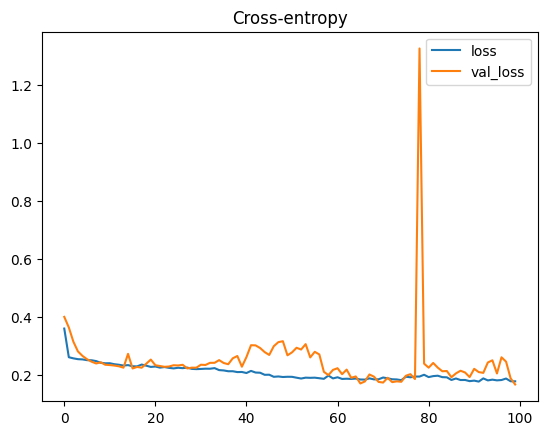

In [26]:
from tensorflow import keras
from keras import layers, models
# model = keras.Sequential([
#     layers.BatchNormalization(input_shape=x_train.shape[1:]),
#     layers.Dense(256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.3),
#     layers.Dense(256, activation='relu'),
#     layers.BatchNormalization(),
#     layers.Dropout(0.5),
#     layers.Dense(1, activation='sigmoid'),
# ])

# model.compile(
#     optimizer='adam',
#     loss='binary_crossentropy',
#     metrics=['binary_accuracy', f1_score],
# )


model = models.Sequential([
    # 1D 컨볼루션 층: 필터의 수, 커널 크기, 활성화 함수를 정의합니다.
    # 데이터가 (샘플 수, 시퀀스 길이, 특성 수) 형태여야 합니다.
    layers.Conv1D(64, 3, activation='relu', input_shape=(28, 1)),
    layers.BatchNormalization(),
    # 1D 최대 풀링 층
    layers.MaxPooling1D(2),
    layers.Conv1D(128, 3, activation='relu'),
    layers.BatchNormalization(),
    layers.MaxPooling1D(2),
    # Flatten 층: 컨볼루션과 풀링 층의 출력을 1D 벡터로 변환합니다.
    layers.Flatten(),
    # 완전 연결(밀집) 층
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    # 출력 층: 이진 분류 문제의 경우 'sigmoid' 활성화 함수를 사용합니다.
    layers.Dense(1, activation='sigmoid'),
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
# 모델을 컴파일합니다.
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', f1_score])


early_stopping = keras.callbacks.EarlyStopping(
    patience=5,
    min_delta=0.001,
    restore_best_weights=True,
)


# history = model.fit(
#     x_train, y_train,
#     validation_data=(x_val, y_val),
#     batch_size=512,
#     epochs=200,
#     callbacks=[early_stopping],
# )
history = model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    batch_size=1024,
    epochs=100
)


history_df = pd.DataFrame(history.history)
history_df.loc[:, ['loss', 'val_loss']].plot(title="Cross-entropy")
history_df.loc[:, ['binary_accuracy', 'val_binary_accuracy']].plot(title="Accuracy")

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

def get_clf_eval(y_test, y_pred=None):

    y_pred = (y_pred > 0.5).astype(int)

    confusion = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    F1 = f1_score(y_test, y_pred)

    print("오차행렬:\n", confusion)
    print("\n정확도: {:.4f}".format(accuracy))
    print("정밀도: {:.4f}".format(precision))
    print("재현율: {:.4f}".format(recall))
    print("F1: {:.4f}".format(F1))

# 모델 예측
pred = model.predict(x_val.fillna(0))
# 성능 평가
get_clf_eval(y_val, pred)


371/371 [==============================] - 0s 1ms/step
오차행렬:
 [[10805   108]
 [  505   442]]

정확도: 0.9483
정밀도: 0.8036
재현율: 0.4667
F1: 0.5905


## 4. 제출하기

### 테스트 데이터 예측

In [28]:
# 예측에 필요한 데이터 분리
x_test = df_test.drop(["is_converted", "id"], axis=1)

In [29]:
test_pred = model.predict(x_test.fillna(0))
y_pred_boolean = test_pred>0.5
sum(y_pred_boolean) # True로 예측된 개수
# print(y_pred_boolean)

165/165 [==============================] - 0s 1ms/step


array([98])

### 제출 파일 작성

In [54]:
# 제출 데이터 읽어오기 (df_test는 전처리된 데이터가 저장됨)
df_sub = pd.read_csv("submission.csv")
df_sub["is_converted"] = y_pred_boolean
print(df_sub)
# 제출 파일 저장
df_sub.to_csv("submission.csv", index=False)

         id  bant_submit                                   customer_country  \
0     19844         0.00                                        /  / Brazil   
1      9738         0.25  400 N State Of Franklin Rd  Cloud IT / Johnson...   
2      8491         1.00                                         /  / U.A.E   
3     19895         0.50                         / Madison  / United States   
4     10465         1.00                               / Sao Paulo / Brazil   
...     ...          ...                                                ...   
5266  13855         0.50                                  /São Paulo/Brazil   
5267   7979         0.25                         General /  / United States   
5268  12887         0.75                             / OURO BRANCO / Brazil   
5269  17530         0.00                                       /  / Germany   
5270   4330         0.25                                  / Ongole  / India   

     business_unit  com_reg_ver_win_rate  customer_

PermissionError: [Errno 13] Permission denied: 'submission.csv'

**우측 상단의 제출 버튼을 클릭해 결과를 확인하세요**